<a href="https://colab.research.google.com/github/SanjayDevTech/TCN/blob/main/TCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!pip uninstall tensorflow tensorflow-io -y -q
!pip install tensorflow -q
!pip install --no-deps tensorflow-io -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 94.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 117.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 57.6 MB/s eta 0:00:00


In [ ]:
!pip install gdown

In [ ]:
import gdown
gdown.download(id="1-1Nr7PpqUaB5j2n38wSALUB1I1vc4hsn", output="mfcc_features_labels.csv")

Downloading...
From: https://drive.google.com/uc?id=1-1Nr7PpqUaB5j2n38wSALUB1I1vc4hsn
To: /content/mfcc_features_labels.csv
100%|██████████| 94.3M/94.3M [00:01<00:00, 62.9MB/s]


'mfcc_features_labels.csv'

In [ ]:
import gdown
gdown.download(id="1X3FlW6veRjYde-onNYngbrI3udOPWO0K", output="checkpoint.zip")
!unzip checkpoint

Downloading...
From: https://drive.google.com/uc?id=1X3FlW6veRjYde-onNYngbrI3udOPWO0K
To: /content/checkpoint.zip
100%|██████████| 15.8M/15.8M [00:00<00:00, 177MB/s]


Archive:  checkpoint.zip
  inflating: checkpoint/checkpoint   
  inflating: checkpoint/model.ckpt.data-00000-of-00001  
  inflating: checkpoint/model.ckpt.index  


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import time
import librosa
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm

In [ ]:
df = pd.read_csv("mfcc_features_labels.csv")

In [ ]:
classes = df["labels"].unique()
classes.sort()
classes = list(classes)
class_to_id = dict([(x, i) for (i, x) in enumerate(classes)])
id_to_class = dict(enumerate(classes))

In [ ]:
!pip show pip

In [ ]:
classes

['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
classes[4]

'happy'

In [ ]:
mfcc = df.iloc[: , :58].to_numpy()
labels = df["labels"]
y = np.array([class_to_id[i] for i in labels])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(mfcc,y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
import joblib

In [ ]:
scaler = joblib.load("mfcc_features_scaler.joblib")

In [ ]:
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
joblib.dump(scaler, "mfcc_features_scaler.joblib")

['mfcc_features_scaler.joblib']

In [ ]:
x_train.shape

(68107, 58)

In [ ]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [ ]:
import inspect
from typing import List

from keras import backend as K, Model, Input, optimizers
from keras import layers
from keras.layers import Activation, SpatialDropout1D, Lambda
from keras.layers import Layer, Conv1D, Dense, BatchNormalization, LayerNormalization


def is_power_of_two(num: int):
    return num != 0 and ((num & (num - 1)) == 0)


def adjust_dilations(dilations: list):
    if all([is_power_of_two(i) for i in dilations]):
        return dilations
    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations


class ResidualBlock(Layer):

    def __init__(self,
                 dilation_rate: int,
                 nb_filters: int,
                 kernel_size: int,
                 padding: str,
                 activation: str = 'relu',
                 dropout_rate: float = 0,
                 kernel_initializer: str = 'he_normal',
                 use_batch_norm: bool = False,
                 use_layer_norm: bool = False,
                 use_weight_norm: bool = False,
                 **kwargs):
        """Defines the residual block for the WaveNet TCN
        Args:
            x: The previous layer in the model
            training: boolean indicating whether the layer should behave in training mode or in inference mode
            dilation_rate: The dilation power of 2 we are using for this residual block
            nb_filters: The number of convolutional filters to use in this block
            kernel_size: The size of the convolutional kernel
            padding: The padding used in the convolutional layers, 'same' or 'causal'.
            activation: The final activation used in o = Activation(x + F(x))
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
            use_batch_norm: Whether to use batch normalization in the residual layers or not.
            use_layer_norm: Whether to use layer normalization in the residual layers or not.
            use_weight_norm: Whether to use weight normalization in the residual layers or not.
            kwargs: Any initializers for Layer class.
        """

        self.dilation_rate = dilation_rate
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.use_weight_norm = use_weight_norm
        self.kernel_initializer = kernel_initializer
        self.layers = []
        self.layers_outputs = []
        self.shape_match_conv = None
        self.res_output_shape = None
        self.final_activation = None

        super(ResidualBlock, self).__init__(**kwargs)

    def _build_layer(self, layer):
        """Helper function for building layer
        Args:
            layer: Appends layer to internal layer list and builds it based on the current output
                   shape of ResidualBlocK. Updates current output shape.
        """
        self.layers.append(layer)
        self.layers[-1].build(self.res_output_shape)
        self.res_output_shape = self.layers[-1].compute_output_shape(self.res_output_shape)

    def build(self, input_shape):

        with K.name_scope(self.name):  # name scope used to make sure weights get unique names
            self.layers = []
            self.res_output_shape = input_shape

            for k in range(2):
                name = 'conv1D_{}'.format(k)
                with K.name_scope(name):  # name scope used to make sure weights get unique names
                    conv = Conv1D(
                        filters=self.nb_filters,
                        kernel_size=self.kernel_size,
                        dilation_rate=self.dilation_rate,
                        padding=self.padding,
                        name=name,
                        kernel_initializer=self.kernel_initializer
                    )
                    if self.use_weight_norm:
                        from tensorflow_addons.layers import WeightNormalization
                        # wrap it. WeightNormalization API is different than BatchNormalization or LayerNormalization.
                        with K.name_scope('norm_{}'.format(k)):
                            conv = WeightNormalization(conv)
                    self._build_layer(conv)

                with K.name_scope('norm_{}'.format(k)):
                    if self.use_batch_norm:
                        self._build_layer(BatchNormalization())
                    elif self.use_layer_norm:
                        self._build_layer(LayerNormalization())
                    elif self.use_weight_norm:
                        pass  # done above.

                self._build_layer(Activation(self.activation))
                self._build_layer(SpatialDropout1D(rate=self.dropout_rate))

            if self.nb_filters != input_shape[-1]:
                # 1x1 conv to match the shapes (channel dimension).
                name = 'matching_conv1D'
                with K.name_scope(name):
                    # make and build this layer separately because it directly uses input_shape
                    self.shape_match_conv = Conv1D(filters=self.nb_filters,
                                                   kernel_size=1,
                                                   padding='same',
                                                   name=name,
                                                   kernel_initializer=self.kernel_initializer)
            else:
                name = 'matching_identity'
                self.shape_match_conv = Lambda(lambda x: x, name=name)

            with K.name_scope(name):
                self.shape_match_conv.build(input_shape)
                self.res_output_shape = self.shape_match_conv.compute_output_shape(input_shape)

            self._build_layer(Activation(self.activation))
            self.final_activation = Activation(self.activation)
            self.final_activation.build(self.res_output_shape)  # probably isn't necessary

            # this is done to force Keras to add the layers in the list to self._layers
            for layer in self.layers:
                self.__setattr__(layer.name, layer)
            self.__setattr__(self.shape_match_conv.name, self.shape_match_conv)
            self.__setattr__(self.final_activation.name, self.final_activation)

            super(ResidualBlock, self).build(input_shape)  # done to make sure self.built is set True

    def call(self, inputs, training=None):
        """
        Returns: A tuple where the first element is the residual model tensor, and the second
                 is the skip connection tensor.
        """
        x = inputs
        self.layers_outputs = [x]
        for layer in self.layers:
            training_flag = 'training' in dict(inspect.signature(layer.call).parameters)
            x = layer(x, training=training) if training_flag else layer(x)
            self.layers_outputs.append(x)
        x2 = self.shape_match_conv(inputs)
        self.layers_outputs.append(x2)
        res_x = layers.add([x2, x])
        self.layers_outputs.append(res_x)

        res_act_x = self.final_activation(res_x)
        self.layers_outputs.append(res_act_x)
        return [res_act_x, x]

    def compute_output_shape(self, input_shape):
        return [self.res_output_shape, self.res_output_shape]


class TCN(Layer):
    """Creates a TCN layer.
        Input shape:
            A tensor of shape (batch_size, timesteps, input_dim).
        Args:
            nb_filters: The number of filters to use in the convolutional layers. Can be a list.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual blocK.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            activation: The activation used in the residual blocks o = Activation(x + F(x)).
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
            use_batch_norm: Whether to use batch normalization in the residual layers or not.
            kwargs: Any other arguments for configuring parent class Layer. For example "name=str", Name of the model.
                    Use unique names when using multiple TCN.
        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=(1, 2, 4, 8, 16, 32),
                 padding='causal',
                 use_skip_connections=False,
                 dropout_rate=0.0,
                 return_sequences=False,
                 activation='relu',
                 kernel_initializer='he_normal',
                 use_batch_norm=False,
                 use_layer_norm=False,
                 use_weight_norm=False,
                 **kwargs):

        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.activation = activation
        self.padding = padding
        self.kernel_initializer = kernel_initializer
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.use_weight_norm = use_weight_norm
        self.skip_connections = []
        self.residual_blocks = []
        self.layers_outputs = []
        self.build_output_shape = None
        self.slicer_layer = None  # in case return_sequence=False
        self.output_slice_index = None  # in case return_sequence=False
        self.padding_same_and_time_dim_unknown = False  # edge case if padding='same' and time_dim = None

        if self.use_batch_norm + self.use_layer_norm + self.use_weight_norm > 1:
            raise ValueError('Only one normalization can be specified at once.')

        if isinstance(self.nb_filters, list):
            assert len(self.nb_filters) == len(self.dilations)

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")

        # initialize parent class
        super(TCN, self).__init__(**kwargs)

    @property
    def receptive_field(self):
        assert_msg = 'The receptive field formula works only with power of two dilations.'
        assert all([is_power_of_two(i) for i in self.dilations]), assert_msg
        return self.kernel_size * self.nb_stacks * self.dilations[-1]

    def build(self, input_shape):

        # member to hold current output shape of the layer for building purposes
        self.build_output_shape = input_shape

        # list to hold all the member ResidualBlocks
        self.residual_blocks = []
        total_num_blocks = self.nb_stacks * len(self.dilations)
        if not self.use_skip_connections:
            total_num_blocks += 1  # cheap way to do a false case for below

        for s in range(self.nb_stacks):
            for i, d in enumerate(self.dilations):
                res_block_filters = self.nb_filters[i] if isinstance(self.nb_filters, list) else self.nb_filters
                self.residual_blocks.append(ResidualBlock(dilation_rate=d,
                                                          nb_filters=res_block_filters,
                                                          kernel_size=self.kernel_size,
                                                          padding=self.padding,
                                                          activation=self.activation,
                                                          dropout_rate=self.dropout_rate,
                                                          use_batch_norm=self.use_batch_norm,
                                                          use_layer_norm=self.use_layer_norm,
                                                          use_weight_norm=self.use_weight_norm,
                                                          kernel_initializer=self.kernel_initializer,
                                                          name='residual_block_{}'.format(len(self.residual_blocks))))
                # build newest residual block
                self.residual_blocks[-1].build(self.build_output_shape)
                self.build_output_shape = self.residual_blocks[-1].res_output_shape

        # this is done to force keras to add the layers in the list to self._layers
        for layer in self.residual_blocks:
            self.__setattr__(layer.name, layer)

        self.output_slice_index = None
        if self.padding == 'same':
            time = self.build_output_shape.as_list()[1]
            if time is not None:  # if time dimension is defined. e.g. shape = (bs, 500, input_dim).
                self.output_slice_index = int(self.build_output_shape.as_list()[1] / 2)
            else:
                # It will known at call time. c.f. self.call.
                self.padding_same_and_time_dim_unknown = True

        else:
            self.output_slice_index = -1  # causal case.
        self.slicer_layer = Lambda(lambda tt: tt[:, self.output_slice_index, :])

    def compute_output_shape(self, input_shape):
        """
        Overridden in case keras uses it somewhere... no idea. Just trying to avoid future errors.
        """
        if not self.built:
            self.build(input_shape)
        if not self.return_sequences:
            batch_size = self.build_output_shape[0]
            batch_size = batch_size.value if hasattr(batch_size, 'value') else batch_size
            nb_filters = self.build_output_shape[-1]
            return [batch_size, nb_filters]
        else:
            # Compatibility tensorflow 1.x
            return [v.value if hasattr(v, 'value') else v for v in self.build_output_shape]

    def call(self, inputs, training=None):
        x = inputs
        self.layers_outputs = [x]
        self.skip_connections = []
        for layer in self.residual_blocks:
            try:
                x, skip_out = layer(x, training=training)
            except TypeError:  # compatibility with tensorflow 1.x
                x, skip_out = layer(K.cast(x, 'float32'), training=training)
            self.skip_connections.append(skip_out)
            self.layers_outputs.append(x)

        if self.use_skip_connections:
            x = layers.add(self.skip_connections)
            self.layers_outputs.append(x)

        if not self.return_sequences:
            # case: time dimension is unknown. e.g. (bs, None, input_dim).
            if self.padding_same_and_time_dim_unknown:
                self.output_slice_index = K.shape(self.layers_outputs[-1])[1] // 2
            x = self.slicer_layer(x)
            self.layers_outputs.append(x)
        return x

    def get_config(self):
        """
        Returns the config of a the layer. This is used for saving and loading from a model
        :return: python dictionary with specs to rebuild layer
        """
        config = super(TCN, self).get_config()
        config['nb_filters'] = self.nb_filters
        config['kernel_size'] = self.kernel_size
        config['nb_stacks'] = self.nb_stacks
        config['dilations'] = self.dilations
        config['padding'] = self.padding
        config['use_skip_connections'] = self.use_skip_connections
        config['dropout_rate'] = self.dropout_rate
        config['return_sequences'] = self.return_sequences
        config['activation'] = self.activation
        config['use_batch_norm'] = self.use_batch_norm
        config['use_layer_norm'] = self.use_layer_norm
        config['use_weight_norm'] = self.use_weight_norm
        config['kernel_initializer'] = self.kernel_initializer
        return config


def compiled_tcn(num_feat,  # type: int
                 num_classes,  # type: int
                 nb_filters,  # type: int
                 kernel_size,  # type: int
                 dilations,  # type: List[int]
                 nb_stacks,  # type: int
                 max_len,  # type: int
                 output_len=1,  # type: int
                 padding='causal',  # type: str
                 use_skip_connections=False,  # type: bool
                 return_sequences=True,
                 regression=False,  # type: bool
                 dropout_rate=0.05,  # type: float
                 name='tcn',  # type: str
                 kernel_initializer='he_normal',  # type: str
                 activation='relu',  # type:str
                 opt='adam',
                 lr=0.002,
                 use_batch_norm=False,
                 use_layer_norm=False,
                 use_weight_norm=False):
    # type: (...) -> Model
    """Creates a compiled TCN model for a given task (i.e. regression or classification).
    Classification uses a sparse categorical loss. Please input class ids and not one-hot encodings.
    Args:
        num_feat: The number of features of your input, i.e. the last dimension of: (batch_size, timesteps, input_dim).
        num_classes: The size of the final dense layer, how many classes we are predicting.
        nb_filters: The number of filters to use in the convolutional layers.
        kernel_size: The size of the kernel to use in each convolutional layer.
        dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
        nb_stacks : The number of stacks of residual blocks to use.
        max_len: The maximum sequence length, use None if the sequence length is dynamic.
        padding: The padding to use in the convolutional layers.
        use_skip_connections: Boolean. If we want to add skip connections from input to each residual blocK.
        return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
        regression: Whether the output should be continuous or discrete.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        activation: The activation used in the residual blocks o = Activation(x + F(x)).
        name: Name of the model. Useful when having multiple TCN.
        kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
        opt: Optimizer name.
        lr: Learning rate.
        use_batch_norm: Whether to use batch normalization in the residual layers or not.
        use_layer_norm: Whether to use layer normalization in the residual layers or not.
        use_weight_norm: Whether to use weight normalization in the residual layers or not.
    Returns:
        A compiled keras TCN.
    """

    dilations = adjust_dilations(dilations)

    input_layer = Input(shape=(max_len, num_feat))

    x = TCN(nb_filters, kernel_size, nb_stacks, dilations, padding,
            use_skip_connections, dropout_rate, return_sequences,
            activation, kernel_initializer, use_batch_norm, use_layer_norm,
            use_weight_norm, name=name)(input_layer)

    print('x.shape=', x.shape)

    def get_opt():
        if opt == 'adam':
            return optimizers.Adam(lr=lr, clipnorm=1.)
        elif opt == 'rmsprop':
            return optimizers.RMSprop(lr=lr, clipnorm=1.)
        else:
            raise Exception('Only Adam and RMSProp are available here')

    if not regression:
        # classification
        x = Dense(num_classes)(x)
        x = Activation('softmax')(x)
        output_layer = x
        model = Model(input_layer, output_layer)

        model.compile(get_opt(), loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    else:
        # regression
        x = Dense(output_len)(x)
        x = Activation('linear')(x)
        output_layer = x
        model = Model(input_layer, output_layer)
        model.compile(get_opt(), loss='mean_squared_error')
    print('model.x = {}'.format(input_layer.shape))
    print('model.y = {}'.format(output_layer.shape))
    return model




In [ ]:
def tcn_full_summary(model: Model, expand_residual_blocks=True):
    layers = model.layers.copy()
    model.layers.clear()

    for i in range(len(layers)):
        if isinstance(layers[i], TCN):
            print(dir(layers[i]))
            for layer in layers[i]._layers:
                if not isinstance(layer, ResidualBlock):
                    if not hasattr(layer, '__iter__'):
                        model.layers.append(layer)
                else:
                    if expand_residual_blocks:
                        for lyr in layer.layers:
                            if not hasattr(lyr, '__iter__'):
                                model.layers.append(lyr)
                    else:
                        model.layers.append(layer)
        else:
            model.layers.append(layers[i])

    model.summary()
    model.layers.clear()
    [model.layers.append(lyr) for lyr in layers]

In [ ]:
x_train.shape[2]

1

In [ ]:
model = compiled_tcn(return_sequences=False,
                    num_feat=x_train.shape[2],
                    num_classes=len(classes),
                    nb_filters=128,
                    kernel_size=9,
                    dilations=[2 ** i for i in range(7)], 
                    nb_stacks=1,
                    dropout_rate=0.3,
                    use_batch_norm=False,
                    max_len=x_train[0:1].shape[1],
                    use_skip_connections=True,
                    use_layer_norm=True,
                    opt='adam')
model.summary()

x.shape= (None, 128)
model.x = (None, 58, 1)
model.y = (None, 8)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 58, 1)]           0         
                                                                 
 tcn (TCN)                   (None, 128)               1923712   
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
 activation_1 (Activation)   (None, 8)                 0         
                                                                 
Total params: 1,924,744
Trainable params: 1,924,744
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.load_weights("checkpoint/model.ckpt")

In [ ]:
tcn_full_summary(model)

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard
mc = ModelCheckpoint(
    "model.ckpt",
    monitor = 'val_accuracy',
    verbose= 1,
    save_best_only = True,
    save_weights_only=True,
)
tfboard = TensorBoard(log_dir="logs/fit/", histogram_freq=1)

In [ ]:
cnnhistory = model.fit(x_train, y_train,
                        batch_size = 32,
                        validation_data=(x_test, y_test),
                        epochs = 250,
                        callbacks=[mc, tfboard],
                        verbose = 1)

Epoch 1/250
2129/2129 [==============================] - ETA: 0s - loss: 1.5719 - accuracy: 0.4019
Epoch 1: val_accuracy improved from -inf to 0.52587, saving model to model.ckpt
2129/2129 [==============================] - 71s 31ms/step - loss: 1.5719 - accuracy: 0.4019 - val_loss: 1.1768 - val_accuracy: 0.5259
Epoch 2/250
2127/2129 [============================>.] - ETA: 0s - loss: 1.1806 - accuracy: 0.5300
Epoch 2: val_accuracy improved from 0.52587 to 0.55905, saving model to model.ckpt
2129/2129 [==============================] - 62s 29ms/step - loss: 1.1804 - accuracy: 0.5301 - val_loss: 1.0851 - val_accuracy: 0.5591
Epoch 3/250
2127/2129 [============================>.] - ETA: 0s - loss: 1.0880 - accuracy: 0.5691
Epoch 3: val_accuracy improved from 0.55905 to 0.59406, saving model to model.ckpt
2129/2129 [==============================] - 62s 29ms/step - loss: 1.0882 - accuracy: 0.5690 - val_loss: 1.0160 - val_accuracy: 0.5941
Epoch 4/250
2128/2129 [============================>

KeyboardInterrupt: ignored

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
models = [compiled_tcn(return_sequences=False,
                    num_feat=x_train.shape[2],
                    num_classes=len(classes),
                    nb_filters=128,
                    kernel_size=9,
                    dilations=[2 ** i for i in range(7)],
                    nb_stacks=1,
                    dropout_rate=0.3,
                    use_batch_norm=False,
                    max_len=x_train[0:1].shape[1],
                    use_skip_connections=True,
                    use_layer_norm=True,
                    opt='adam') for x in range(4)]

x.shape= (None, 128)
model.x = (None, 58, 1)
model.y = (None, 8)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


x.shape= (None, 128)
model.x = (None, 58, 1)
model.y = (None, 8)
x.shape= (None, 128)
model.x = (None, 58, 1)
model.y = (None, 8)
x.shape= (None, 128)
model.x = (None, 58, 1)
model.y = (None, 8)


In [ ]:
def mfcc_from_wav(filepath):
  data, sr = librosa.load(filepath)
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr,
                                              n_mfcc=58).T, axis=0)
  return scaler.transform([mfcc])

In [ ]:
probs = new_model.predict([mfcc_from_wav("wav.wav")])[0]
np.argmax(probs)

1/1 [==============================] - 0s 29ms/step


4

In [ ]:
!unzip ckpt.zip

In [ ]:
!tensorboard dev upload --logdir logs/fit

In [ ]:
for i, model in enumerate(models):
  model.load_weights(f"v{i+1}/model.ckpt")
  model.evaluate(x_test, y_test)

533/533 [==============================] - 119s 219ms/step - loss: 0.2017 - accuracy: 0.9366


In [ ]:
model = models[2]

In [ ]:
model.evaluate(x_test, y_test)

 39/533 [=>............................] - ETA: 1:42 - loss: 0.1982 - accuracy: 0.9295

KeyboardInterrupt: ignored

In [ ]:
model.save("saved_model_again")

In [ ]:
import keras
model = keras.models.load_model("saved_model")

In [ ]:
model.evaluate(x_test, y_test)

533/533 [==============================] - 138s 258ms/step - loss: 0.2000 - accuracy: 0.9352


[0.1999737024307251, 0.9352205395698547]

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite = converter.convert()

In [ ]:
with open('model.tflite', 'wb') as f:
  f.write(tflite)

In [ ]:
!zip -r saved_model.zip saved_model/*

  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/keras_metadata.pb (deflated 93%)
  adding: saved_model/saved_model.pb (deflated 93%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 80%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 32%)


In [ ]:
!rm -r saved_model

In [ ]:
!unzip saved_model

In [ ]:
predictions = model.predict(x_test)

533/533 [==============================] - 125s 234ms/step


In [ ]:
y_pred = [id_to_class[np.argmax(probs)] for probs in predictions]
y_true = [id_to_class[test] for test in y_test]

In [ ]:
y_pred = [np.argmax(probs) for probs in predictions]
y_true = [test for test in y_test]

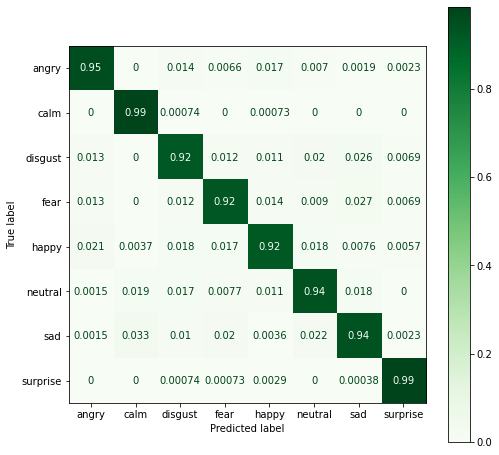

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = classes
cm = confusion_matrix(y_true, y_pred)
cm = cm / cm.astype(float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(cmap=plt.cm.Greens, ax = ax)
plt.show()
disp.figure_.savefig('confusion_matrix.png')